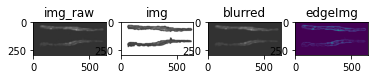

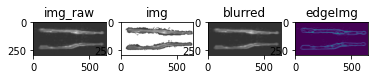

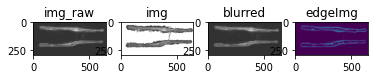

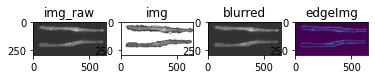

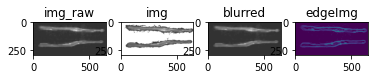

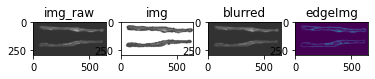

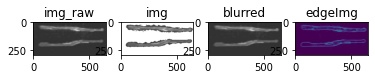

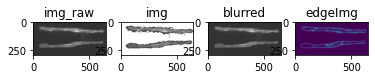

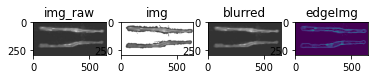

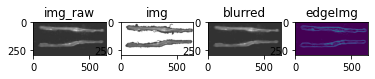

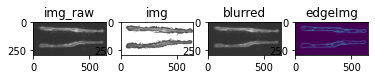

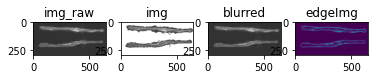

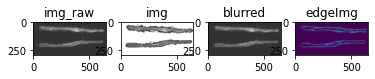

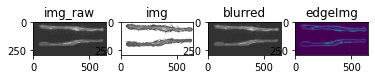

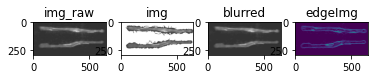

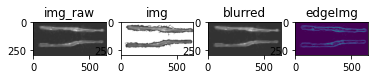

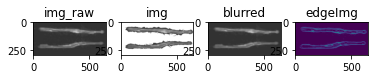

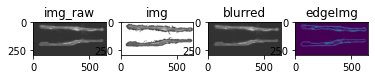

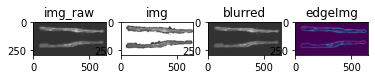

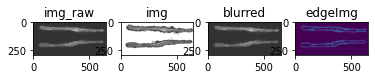

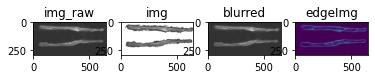

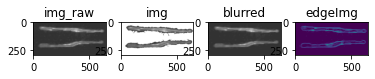

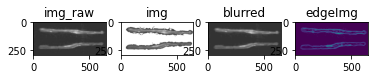

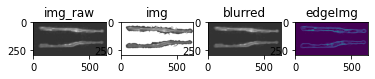

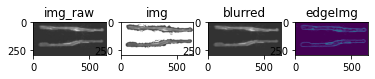

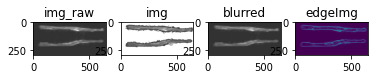

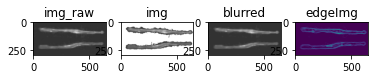

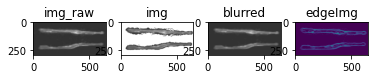

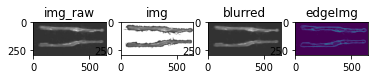

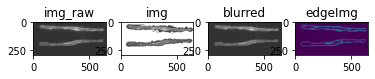

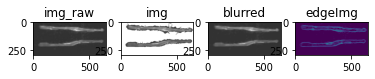

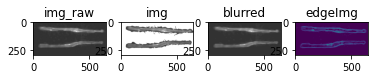

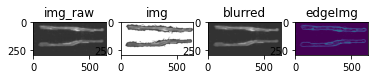

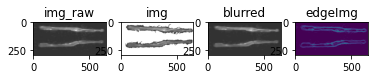

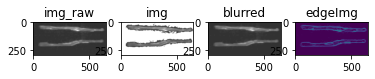

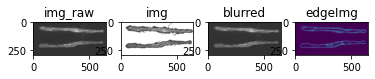

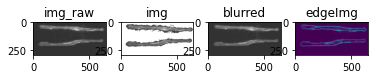

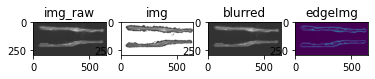

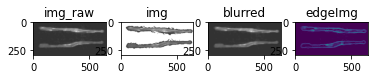

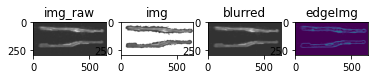

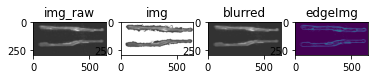

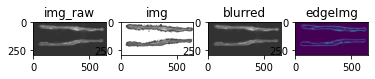

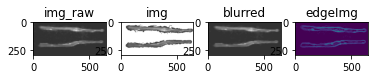

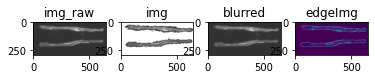

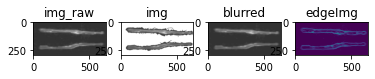

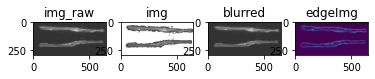

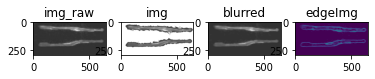

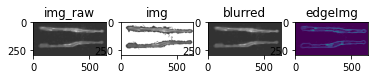

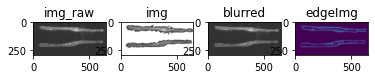

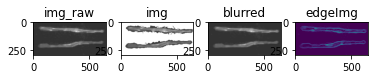

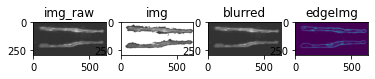

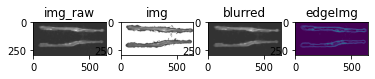

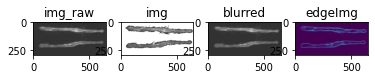

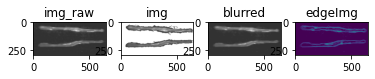

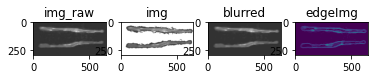

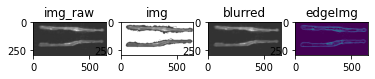

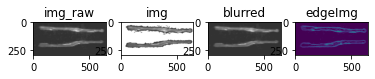

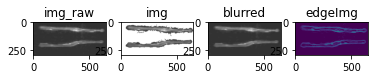

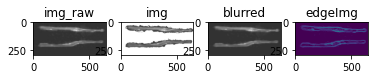

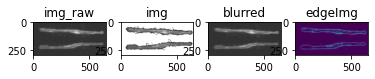

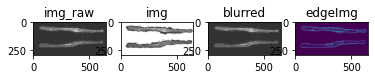

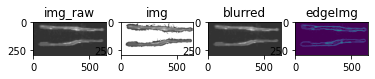

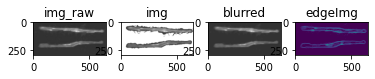

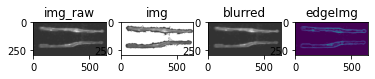

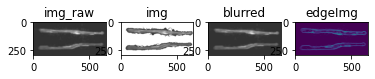

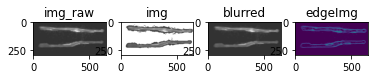

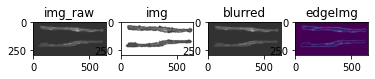

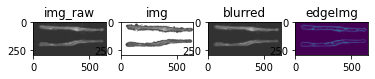

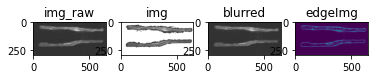

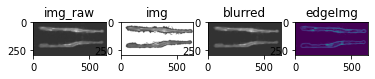

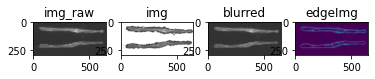

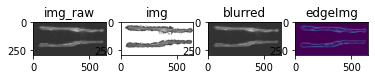

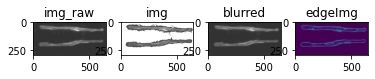

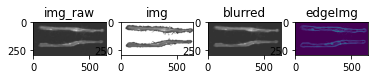

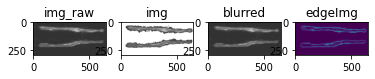

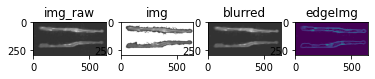

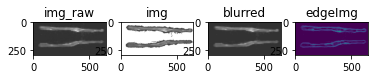

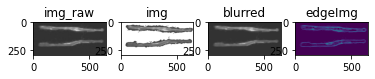

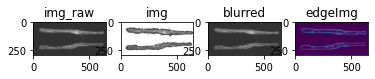

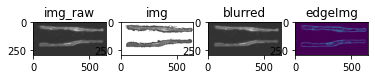

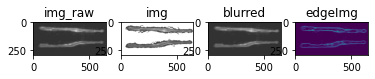

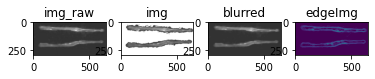

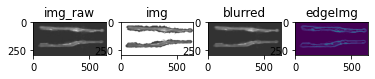

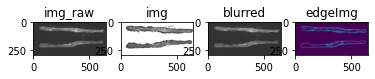

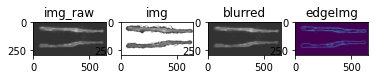

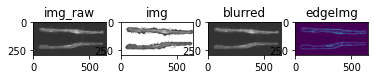

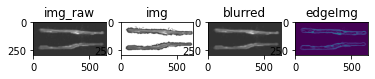

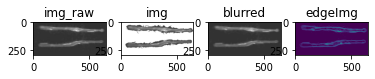

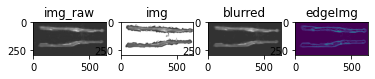

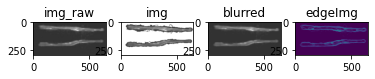

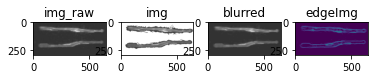

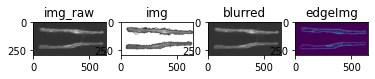

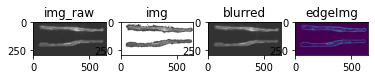

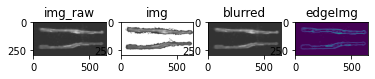

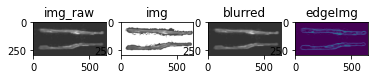

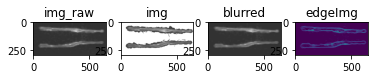

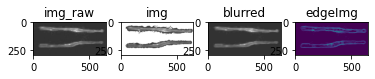

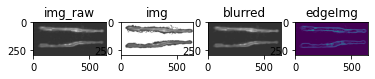

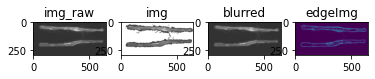

 100 of Image  pre-processed


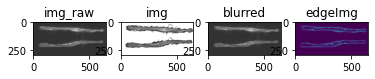

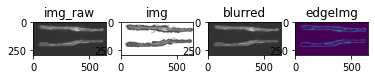

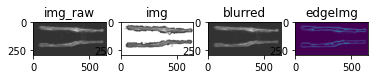

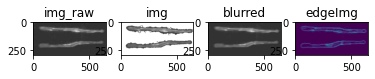

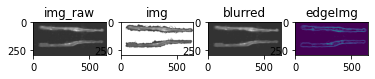

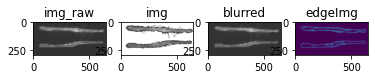

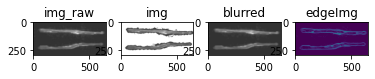

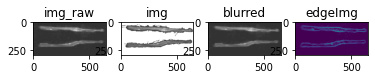

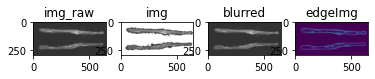

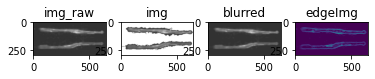

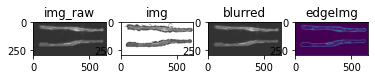

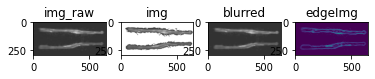

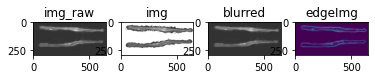

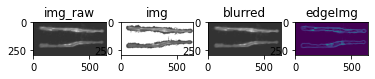

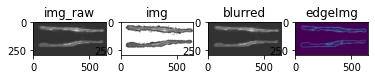

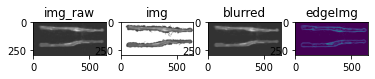

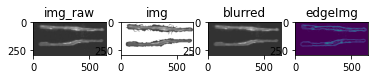

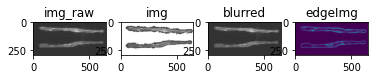

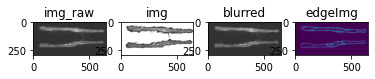

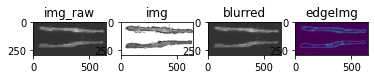

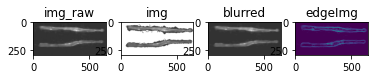

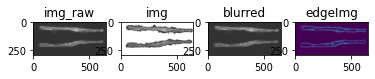

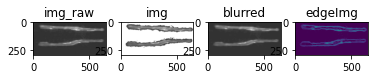

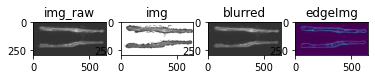

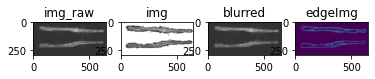

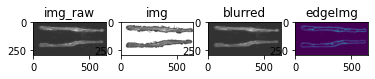

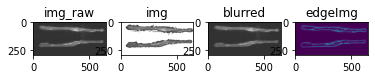

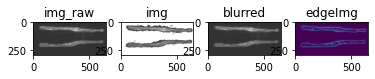

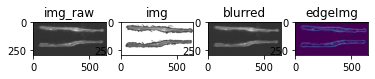

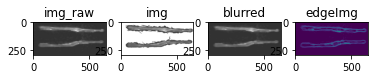

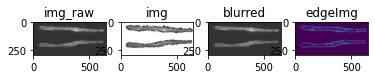

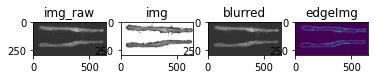

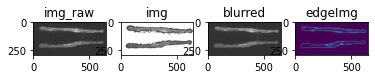

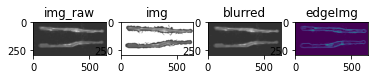

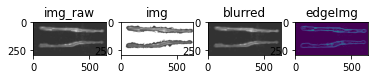

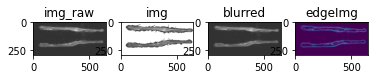

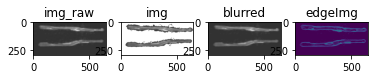

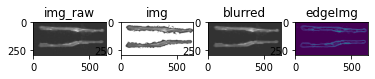

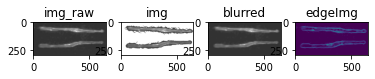

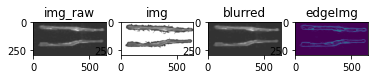

KeyboardInterrupt: 

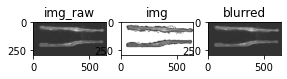

In [4]:
"""
이미지 폴더에 있는 상품 이미지의 배경을 제거하는 모듈
"""
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from config import *

def edgedetect (channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)

    sobel[sobel > 255] = 255; # Some values seem to go above 255. However RGB channels has to be within 0-255

    return sobel


def findSignificantContours (img, edgeImg):
    contours, heirarchy = cv2.findContours(edgeImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find level 1 contours
    level1 = []
    for i, tupl in enumerate(heirarchy[0]):
        # Each array is in format (Next, Prev, First child, Parent)
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            level1.append(tupl)


    # From among them, find the contours with large surface area.
    significant = []
    tooSmall = edgeImg.size * 5 / 100 # If contour isn't covering 5% of total area of image then it probably is too small
    for tupl in level1:
        contour = contours[tupl[0]];

        area = cv2.contourArea(contour)
        if area > tooSmall:
            significant.append([contour, area])

    significant.sort(key=lambda x: x[1])
    #print ([x[1] for x in significant]);
    return [x[0] for x in significant];



# get list of files
RAW_IMG_DIR = './raw_image'
IMG_DIR = './img'
img_paths = os.listdir(RAW_IMG_DIR)
count = 0

for f_name in img_paths:
    count += 1
    image = os.path.join(RAW_IMG_DIR,f_name)
    img_raw = cv2.imread(image)
    img = img_raw.copy()

    # Remove noise
    blurred = cv2.medianBlur(img, 9)

    # Edging
    edgeImg = np.max(np.array([edgedetect(blurred[:, :, 0]), edgedetect(blurred[:, :, 1]), edgedetect(blurred[:, :, 2])]), axis=0)

    # Zero any value that is less than mean. This reduces a lot of noise.
    mean = np.mean(edgeImg);
    edgeImg[edgeImg <= mean] = 0;

    # Find contours
    edgeImg_8u = np.asarray(edgeImg, np.uint8)
    significant = findSignificantContours(img, edgeImg_8u)

    # Masking
    mask = edgeImg.copy()
    mask[mask > 0] = 0
    cv2.fillPoly(mask, significant, 255)

    # Invert mask
    mask = np.logical_not(mask)

    # Remove the background
    img[mask] = -1

    if count % 100 == 0:
        print(' %s of Image  pre-processed' % count)

    test = False
    if test == True:
        # Pre_processing Testing Scrren
        images = [img_raw, img, blurred, edgeImg]
        titles = ['img_raw', 'img', 'blurred', 'edgeImg']

        for i in range(len(images)):
            plt.subplot(1, 4, i + 1), plt.imshow(images[i]), plt.title(titles[i])
        mng = plt.get_current_fig_manager()
        mng.resize(1280,768)
        plt.show()
    else:
        # Pre_precessed image save
        cv2.imwrite(os.path.join(IMG_DIR, f_name), img)

print(' Total %s of Image  pre-processed' % count)
